In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff


Q = 0.2 # permanent charge
t_end = 10
t1   =  np.linspace(0, t_end, 100)
t2  =  np.linspace(0, t_end, 100)
eps = 0.1
T_slow_end = 1
tau1 = np.linspace(0, T_slow_end/3, 100)
tau2 = np.linspace(0, T_slow_end/3, 100)
tau3 = np.linspace(0, T_slow_end/3, 100)

tau1_tensor = torch.tensor(tau1.reshape(-1, 1), dtype=torch.float64)
t1_tensor = torch.tensor(t1.reshape(-1, 1), dtype=torch.float64) 
tau2_tensor = torch.tensor(tau2.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)
tau3_tensor = torch.tensor(tau3.reshape(-1, 1), dtype=torch.float64)


def input_transform(tau1_tensor):
    return torch.cat([tau1_tensor], dim=1)

num_nrn = 7

class slow_system_PINN1(nn.Module):
    def __init__(self):
        super(slow_system_PINN1, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, tau1):
        x = F.tanh(self.fc1(tau1))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class fast_system_PINN1(nn.Module):
    def __init__(self):
        super(fast_system_PINN1, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, t1):
        x = F.tanh(self.fc1(t1))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN2(nn.Module):
    def __init__(self):
        super(slow_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, tau2):
        x = F.tanh(self.fc1(tau2))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
      
class fast_system_PINN2(nn.Module):
    def __init__(self):
        super(fast_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, t2):
        x = F.tanh(self.fc1(t2))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN3(nn.Module):
    def __init__(self):
        super(slow_system_PINN3, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, tau3):
        x = F.tanh(self.fc1(tau3))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [2]:
z1, z2 = 1.0 , -1.0
V  = -10
l  = 1.0
l1 = l 
l2 = l 


r  = 0.5
r1 =  r  
r2 =  r 


In [3]:
# Initial points:
phi_init, c1_init, c2_init,  w_init =V, l1 , l2, 0.0  
print('The initial points of the BVP:', f"phi_init  = {phi_init}, c1_init  = {c1_init}, c2_init = {c2_init}, w_init   = {w_init} ")

u_0 =  0.0

phi_end, c1_end, c2_end, w_end =  0.0, r1, r2 , 1.0
print('The ending points of the BVP:', f"phi_end  = {phi_end}, c1_end  = {c1_end}, c2_end = {c2_end}, w_end   = {w_end} ")


c1_s_a_l, c2_s_a_l, phi_s_a_l = np.random.uniform(0, 1) , np.random.uniform(0, 1) , np.random.uniform(0, 1)
c1_f_a_l, c2_f_a_l, phi_f_a_l = np.random.uniform(0, 1) , np.random.uniform(0, 1) , np.random.uniform(0, 1)
c1_s_a_r, c2_s_a_r, phi_s_a_r  = np.random.uniform(0, 1) , np.random.uniform(0, 1) , np.random.uniform(0, 1)
c1_f_a_r, c2_f_a_r, phi_f_a_r  = np.random.uniform(0, 1) , np.random.uniform(0, 1) , np.random.uniform(0, 1)
c1_s_b_l, c2_s_b_l, phi_s_b_l = np.random.uniform(0, 1) , np.random.uniform(0, 1) , np.random.uniform(0, 1)
c1_f_b_l, c2_f_b_l, phi_f_b_l = np.random.uniform(0, 1) , np.random.uniform(0, 1) , np.random.uniform(0, 1)
c1_s_b_r, c2_s_b_r, phi_s_b_r  = np.random.uniform(0, 1) , np.random.uniform(0, 1) , np.random.uniform(0, 1)
c1_f_b_r, c2_f_b_r, phi_f_b_r  = np.random.uniform(0, 1) , np.random.uniform(0, 1) , np.random.uniform(0, 1)
J1, J2 = np.random.uniform(0, 1) , np.random.uniform(0, 1)


w_a = 1/3  # assumed that the end of the first piece is at 1/3
w_b = 2/3  # assumed that the beginning of the last piece is at 2/3




The initial points of the BVP: phi_init  = -10, c1_init  = 1.0, c2_init = 1.0, w_init   = 0.0 
The ending points of the BVP: phi_end  = 0.0, c1_end  = 0.5, c2_end = 0.5, w_end   = 1.0 


In [4]:
phys_weight  = 1
init_weight  = 1
bndry_weight = 1
def loss_func_slow1(model, tau1_tensor, c1_init, c2_init, w_init, phi_init,  eps):
    tau1_tensor.requires_grad = True
    pred_slow1 = model(tau1_tensor)
    phi_pred_slow1, u_pred_slow1 = pred_slow1[:, 0].unsqueeze(1), pred_slow1[:, 1].unsqueeze(1)
    c1_pred_slow1, c2_pred_slow1 = pred_slow1[:, 2].unsqueeze(1), pred_slow1[:, 3].unsqueeze(1)
    j1_pred_slow1, j2_pred_slow1 = pred_slow1[:, 4].unsqueeze(1), pred_slow1[:, 5].unsqueeze(1)
    w_pred_slow1 = pred_slow1[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dtau1 = torch.autograd.grad(phi_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    du_dtau1 = torch.autograd.grad(u_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dtau1 = torch.autograd.grad(c1_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dtau1 = torch.autograd.grad(c2_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dtau1 = torch.autograd.grad(j1_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dtau1 = torch.autograd.grad(j2_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    dw_dtau1 = torch.autograd.grad(w_pred_slow1.sum(), tau1_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    p1 = - (z1 * j1_pred_slow1 + z2 * j2_pred_slow1)/(z1 * (z1 - z2) * c1_pred_slow1)
    #p1 = (z1 * j1_pred_slow1 + z2 * j2_pred_slow1) #/(z1 * (z1 - z2) * c1_pred_slow1)
    residual1_slow1 = u_pred_slow1 #- eps * p
    residual2_slow1 = dphi_dtau1 - p1
    residual3_slow1 = dc1_dtau1 + z1 * c1_pred_slow1 * p1 + j1_pred_slow1 #* (z1 - z2)*z1*c1_pred_slow
    residual4_slow1 = dc2_dtau1 + z2 * c2_pred_slow1 * p1 + j2_pred_slow1 #* (z1 - z2)*z1*c1_pred_slow
    residual5_slow1 = dj1_dtau1
    residual6_slow1 = dj2_dtau1 
    residual7_slow1 = dw_dtau1 - 1 # - (z1 - z2) * z1 * c1_pred_slow
    residual8_slow1 = z1 * c1_pred_slow1 + z2 * c2_pred_slow1

    
    # for non-negativity of c1_pred_fast and c2_pred_fast
    residual_non_neg_c1s1 = torch.clamp(-c1_pred_slow1, min=0)
    residual_non_neg_c2s1 = torch.clamp(-c2_pred_slow1, min=0)
       
    
    init_loss_slow1 = torch.square(phi_pred_slow1[0] - phi_init) +\
                     torch.square(u_pred_slow1[0] - u_0) +\
                     torch.square(c1_pred_slow1[0] - c1_init)  +\
                     torch.square(c2_pred_slow1[0] - c2_init)  +\
                     torch.square(w_pred_slow1[0] - w_init)  +\
                     torch.square(j1_pred_slow1[0] - J1) +\
                     torch.square(j2_pred_slow1[0] - J2) 

    physics_loss_slow1 = torch.mean(residual1_slow1**2 + residual2_slow1**2 +\
                                   residual3_slow1**2 + residual4_slow1**2 +\
                                   residual5_slow1**2 + residual6_slow1**2 +\
                                   residual7_slow1**2 + residual8_slow1**2+\
                                   residual_non_neg_c1s1**2 + residual_non_neg_c2s1**2)
    boundary_loss_slow1 =   torch.square(phi_pred_slow1[-1] - phi_s_a_l) +\
                           torch.square(u_pred_slow1[-1] - u_0) +\
                           torch.square(c1_pred_slow1[-1] - c1_s_a_l)  +\
                           torch.square(c2_pred_slow1[-1] - c2_s_a_l)  +\
                           torch.square(j1_pred_slow1[-1] - j1_pred_slow1[0])+\
                           torch.square(j2_pred_slow1[-1] - j2_pred_slow1[0])+\
                           torch.square(w_pred_slow1[-1] - w_a) 
    
    
    total_loss_slow1   = phys_weight * physics_loss_slow1 +\
                        init_weight * init_loss_slow1 + bndry_weight * boundary_loss_slow1
    return total_loss_slow1

def loss_func_fast1(model, t1_tensor, eps):
    t1_tensor.requires_grad = True
    pred_fast1 = model(t1_tensor)
    phi_pred_fast1, u_pred_fast1 = pred_fast1[:, 0].unsqueeze(1), pred_fast1[:, 1].unsqueeze(1)
    c1_pred_fast1, c2_pred_fast1 = pred_fast1[:, 2].unsqueeze(1), pred_fast1[:, 3].unsqueeze(1)
    j1_pred_fast1, j2_pred_fast1 = pred_fast1[:, 4].unsqueeze(1), pred_fast1[:, 5].unsqueeze(1)
    w_pred_fast1 = pred_fast1[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dt1 = torch.autograd.grad(phi_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    du_dt1 = torch.autograd.grad(u_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dt1 = torch.autograd.grad(c1_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dt1 = torch.autograd.grad(c2_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dt1 = torch.autograd.grad(j1_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dt1 = torch.autograd.grad(j2_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    dw_dt1 = torch.autograd.grad(w_pred_fast1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
   
    # Second derivatives for curvature regularization
    #d2c1_dt1 = torch.autograd.grad(dc1_dt1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]
    #d2c2_dt1 = torch.autograd.grad(dc2_dt1.sum(), t1_tensor, retain_graph=True, create_graph=True)[0]

    # Curvature loss for dc1_dt1 - dc2_dt1
    #curvature_loss = torch.mean((d2c1_dt1 - d2c2_dt1) ** 2)  # Penalize the difference in second derivatives
    #for the fast system
    residual1_fast1 =  dphi_dt1 - u_pred_fast1
    residual2_fast1 =  du_dt1 + z1 * c1_pred_fast1 + z2 * c2_pred_fast1 + Q
    residual3_fast1 =  dc1_dt1 + z1 * c1_pred_fast1 * u_pred_fast1 + eps * j1_pred_fast1
    residual4_fast1 =  dc2_dt1 + z2 * c2_pred_fast1 * u_pred_fast1 + eps * j2_pred_fast1
    residual5_fast1 =  dj1_dt1  
    residual6_fast1 =  dj2_dt1 
    residual7_fast1 =  dw_dt1 #- eps
    residual8_fast1 = w_pred_fast1 - w_a

    

    # for non-negativity of c1_pred_fast and c2_pred_fast
    residual_non_neg_c1f1 = torch.clamp(-c1_pred_fast1, min=0)
    residual_non_neg_c2f1 = torch.clamp(-c2_pred_fast1, min=0)
    
    init_loss_fast1 = torch.square(phi_pred_fast1[0] - phi_s_a_l) +\
                     torch.square(u_pred_fast1[0] - u_0) +\
                     torch.square(c1_pred_fast1[0] - c1_s_a_l)  +\
                     torch.square(c2_pred_fast1[0] - c2_s_a_l)  +\
                     torch.square(w_pred_fast1[0] - w_a) +\
                     torch.square(j1_pred_fast1[0] - J1) +\
                     torch.square(j2_pred_fast1[0] - J2) +\
                     torch.square(z1*c1_pred_fast1[0] + z2*c2_pred_fast1[0]) 
    
    physics_loss_fast1 = torch.mean(residual1_fast1**2 + residual2_fast1**2 +\
                                   residual3_fast1**2 + residual4_fast1**2 +\
                                   residual5_fast1**2 + residual6_fast1**2 +\
                                   residual7_fast1**2 + residual8_fast1**2 +\
                                   residual_non_neg_c1f1**2 + residual_non_neg_c2f1**2)#+\
                           #0.5 * curvature_loss
    boundary_loss_fast1 = torch.square(phi_pred_fast1[-1] - phi_s_a_r) +\
                         torch.square(u_pred_fast1[-1] - u_0) +\
                         torch.square(c1_pred_fast1[-1] - c1_s_a_r) +\
                         torch.square(c2_pred_fast1[-1] - c2_s_a_r) +\
                         torch.square(j1_pred_fast1[-1] - j1_pred_fast1[0])+\
                         torch.square(j2_pred_fast1[-1] - j2_pred_fast1[0])+\
                         torch.square(w_pred_fast1[-1] - w_a)+\
                         torch.square(z1*c1_pred_fast1[-1] + z2*c2_pred_fast1[-1] + Q)

        
    total_loss_fast1   = phys_weight * physics_loss_fast1 +\
                        init_weight * init_loss_fast1 + bndry_weight * boundary_loss_fast1
                        
    return total_loss_fast1

def loss_func_slow2(model, tau2_tensor, eps):
    tau2_tensor.requires_grad = True
    pred_slow2 = model(tau2_tensor)
    phi_pred_slow2, u_pred_slow2 = pred_slow2[:, 0].unsqueeze(1), pred_slow2[:, 1].unsqueeze(1)
    c1_pred_slow2, c2_pred_slow2 = pred_slow2[:, 2].unsqueeze(1), pred_slow2[:, 3].unsqueeze(1)
    j1_pred_slow2, j2_pred_slow2 = pred_slow2[:, 4].unsqueeze(1), pred_slow2[:, 5].unsqueeze(1)
    w_pred_slow2 = pred_slow2[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dtau2 = torch.autograd.grad(phi_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    du_dtau2 = torch.autograd.grad(u_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dtau2 = torch.autograd.grad(c1_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dtau2 = torch.autograd.grad(c2_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dtau2 = torch.autograd.grad(j1_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dtau2 = torch.autograd.grad(j2_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    dw_dtau2 = torch.autograd.grad(w_pred_slow2.sum(), tau2_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    p2 = - (z1 * j1_pred_slow2 + z2 * j2_pred_slow2)/(z1 * (z1 - z2) * c1_pred_slow2- z2*Q)
    
    residual1_slow2 = u_pred_slow2 #- eps * p
    residual2_slow2 = dphi_dtau2 - p2
    residual3_slow2 = dc1_dtau2 + z1 * c1_pred_slow2 * p2 + j1_pred_slow2 #* (z1 - z2)*z1*c1_pred_slow
    residual4_slow2 = dc2_dtau2 + z2 * c2_pred_slow2 * p2 + j2_pred_slow2 #* (z1 - z2)*z1*c1_pred_slow
    residual5_slow2 = dj1_dtau2
    residual6_slow2 = dj2_dtau2 
    residual7_slow2 = dw_dtau2 - 1 # - (z1 - z2) * z1 * c1_pred_slow
    residual8_slow2 = z1 * c1_pred_slow2 + z2 * c2_pred_slow2 + Q

    # for non-negativity of c1_pred_fast and c2_pred_fast
    residual_non_neg_c1s2 = torch.clamp(-c1_pred_slow2, min=0)
    residual_non_neg_c2s2 = torch.clamp(-c2_pred_slow2, min=0)
       
    
    init_loss_slow2 = torch.square(phi_pred_slow2[0] - phi_s_a_r) +\
                     torch.square(u_pred_slow2[0] - u_0) +\
                     torch.square(c1_pred_slow2[0] - c1_s_a_r)  +\
                     torch.square(c2_pred_slow2[0] - c2_s_a_r)  +\
                     torch.square(w_pred_slow2[0] - w_a)  +\
                     torch.square(j1_pred_slow2[0] - J1) +\
                     torch.square(j2_pred_slow2[0] - J2) 

    physics_loss_slow2 = torch.mean(residual1_slow2**2 + residual2_slow2**2 +\
                                   residual3_slow2**2 + residual4_slow2**2 +\
                                   residual5_slow2**2 + residual6_slow2**2 +\
                                   residual7_slow2**2 + residual8_slow2**2+\
                                   residual_non_neg_c1s2**2 + residual_non_neg_c2s2**2)
    boundary_loss_slow2 =   torch.square(phi_pred_slow2[-1] - phi_s_b_l) +\
                           torch.square(u_pred_slow2[-1] - u_0) +\
                           torch.square(c1_pred_slow2[-1] - c1_s_b_l)  +\
                           torch.square(c2_pred_slow2[-1] - c2_s_b_l)  +\
                           torch.square(j1_pred_slow2[-1] - j1_pred_slow2[0])+\
                           torch.square(j2_pred_slow2[-1] - j2_pred_slow2[0])+\
                           torch.square(w_pred_slow2[-1] - w_b) 
    total_loss_slow2   = phys_weight * physics_loss_slow2 +\
                        init_weight * init_loss_slow2 + bndry_weight * boundary_loss_slow2
    return total_loss_slow2
    


def loss_func_fast2(model, t2_tensor, eps):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    phi_pred_fast2, u_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1)
    c1_pred_fast2, c2_pred_fast2 = pred_fast2[:, 2].unsqueeze(1), pred_fast2[:, 3].unsqueeze(1)
    j1_pred_fast2, j2_pred_fast2 = pred_fast2[:, 4].unsqueeze(1), pred_fast2[:, 5].unsqueeze(1)
    w_pred_fast2 = pred_fast2[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dt2 = torch.autograd.grad(phi_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    du_dt2 = torch.autograd.grad(u_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dt2 = torch.autograd.grad(c1_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dt2 = torch.autograd.grad(c2_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dt2 = torch.autograd.grad(j1_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dt2 = torch.autograd.grad(j2_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dw_dt2 = torch.autograd.grad(w_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    residual1_fast2 =  dphi_dt2 - u_pred_fast2
    residual2_fast2 =  du_dt2 + z1 * c1_pred_fast2 + z2 * c2_pred_fast2 + Q
    residual3_fast2 =  dc1_dt2 + z1 * c1_pred_fast2 * u_pred_fast2 + eps * j1_pred_fast2
    residual4_fast2 =  dc2_dt2 + z2 * c2_pred_fast2 * u_pred_fast2 + eps * j2_pred_fast2
    residual5_fast2 =  dj1_dt2  
    residual6_fast2 =  dj2_dt2 
    residual7_fast2 =  dw_dt2 #- eps
    residual8_fast2 = w_pred_fast2 - w_b

    # for non-negativity of c1_pred_fast and c2_pred_fast
    residual_non_neg_c1f2 = torch.clamp(-c1_pred_fast2, min=0)
    residual_non_neg_c2f2 = torch.clamp(-c2_pred_fast2, min=0)

    
    init_loss_fast2 = torch.square(phi_pred_fast2[0] - phi_s_b_l) +\
                      torch.square(u_pred_fast2[0] - u_0) +\
                      torch.square(c1_pred_fast2[0] - c1_s_b_l)  +\
                      torch.square(c2_pred_fast2[0] - c2_s_b_l)  +\
                      torch.square(w_pred_fast2[0] - w_b) +\
                      torch.square(j1_pred_fast2[0] - J1) +\
                      torch.square(j2_pred_fast2[0] - J2) +\
                      torch.square(z1*c1_pred_fast2[0] + z2*c2_pred_fast2[0] + Q) 
    
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2 +\
                                   residual3_fast2**2 + residual4_fast2**2 +\
                                   residual5_fast2**2 + residual6_fast2**2 +\
                                   residual7_fast2**2 + residual8_fast2**2 +\
                                  residual_non_neg_c1f2**2 + residual_non_neg_c2f2**2)
    boundary_loss_fast2 = torch.square(phi_pred_fast2[-1] - phi_s_b_r) +\
                          torch.square(u_pred_fast2[-1] - u_0) +\
                          torch.square(c1_pred_fast2[-1] - c1_s_b_r) +\
                          torch.square(c2_pred_fast2[-1] - c2_s_b_r) +\
                          torch.square(j1_pred_fast2[-1] - j1_pred_fast2[0])+\
                          torch.square(j2_pred_fast2[-1] - j2_pred_fast2[0])+\
                          torch.square(w_pred_fast2[-1] - w_b) +\
                          torch.square(z1*c1_pred_fast2[-1] + z2*c2_pred_fast2[-1]) 
    
    total_loss_fast2   = phys_weight * physics_loss_fast2 +\
                         init_weight * init_loss_fast2 + bndry_weight * boundary_loss_fast2
    return total_loss_fast2


def loss_func_slow3(model, tau3_tensor, c1_end, c2_end, w_end, phi_end, eps):
    tau3_tensor.requires_grad = True
    pred_slow3 = model(tau3_tensor)
    phi_pred_slow3, u_pred_slow3 = pred_slow3[:, 0].unsqueeze(1), pred_slow3[:, 1].unsqueeze(1)
    c1_pred_slow3, c2_pred_slow3 = pred_slow3[:, 2].unsqueeze(1), pred_slow3[:, 3].unsqueeze(1)
    j1_pred_slow3, j2_pred_slow3 = pred_slow3[:, 4].unsqueeze(1), pred_slow3[:, 5].unsqueeze(1)
    w_pred_slow3 = pred_slow3[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dtau3 = torch.autograd.grad(phi_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    du_dtau3 = torch.autograd.grad(u_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dtau3 = torch.autograd.grad(c1_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dtau3 = torch.autograd.grad(c2_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dtau3 = torch.autograd.grad(j1_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dtau3 = torch.autograd.grad(j2_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    dw_dtau3 = torch.autograd.grad(w_pred_slow3.sum(), tau3_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    p3 = - (z1 * j1_pred_slow3 + z2 * j2_pred_slow3)/(z1 * (z1 - z2) * c1_pred_slow3)
    
    residual1_slow3 = u_pred_slow3 #- eps * p
    residual2_slow3 = dphi_dtau3 - p3
    residual3_slow3 = dc1_dtau3 + z1 * c1_pred_slow3 * p3 + j1_pred_slow3 #* (z1 - z2)*z1*c1_pred_slow
    residual4_slow3 = dc2_dtau3 + z2 * c2_pred_slow3 * p3 + j2_pred_slow3 #* (z1 - z2)*z1*c1_pred_slow
    residual5_slow3 = dj1_dtau3
    residual6_slow3 = dj2_dtau3 
    residual7_slow3 = dw_dtau3 - 1 # - (z1 - z2) * z1 * c1_pred_slow
    residual8_slow3 = z1 * c1_pred_slow3 + z2 * c2_pred_slow3

    # for non-negativity of c1_pred_fast and c2_pred_fast
    residual_non_neg_c1s3 = torch.clamp(-c1_pred_slow3, min=0)
    residual_non_neg_c2s3 = torch.clamp(-c2_pred_slow3, min=0)
       
    
    init_loss_slow3 = torch.square(phi_pred_slow3[0] - phi_s_b_r) +\
                     torch.square(u_pred_slow3[0] - u_0) +\
                     torch.square(c1_pred_slow3[0] - c1_s_b_r)  +\
                     torch.square(c2_pred_slow3[0] - c2_s_b_r)  +\
                     torch.square(w_pred_slow3[0] - w_b)  +\
                     torch.square(j1_pred_slow3[0] - J1) +\
                     torch.square(j2_pred_slow3[0] - J2) 

    physics_loss_slow3 = torch.mean(residual1_slow3**2 + residual2_slow3**2 +\
                                   residual3_slow3**2 + residual4_slow3**2 +\
                                   residual5_slow3**2 + residual6_slow3**2 +\
                                   residual7_slow3**2 + residual8_slow3**2+\
                                   residual_non_neg_c1s3**2 + residual_non_neg_c2s3**2)
    boundary_loss_slow3 =   torch.square(phi_pred_slow3[-1] - phi_end) +\
                           torch.square(u_pred_slow3[-1] - u_0) +\
                           torch.square(c1_pred_slow3[-1] - c1_end)  +\
                           torch.square(c2_pred_slow3[-1] - c2_end)  +\
                           torch.square(j1_pred_slow3[-1] - j1_pred_slow3[0])+\
                           torch.square(j2_pred_slow3[-1] - j2_pred_slow3[0])+\
                           torch.square(w_pred_slow3[-1] - w_end) 
    total_loss_slow3   = phys_weight * physics_loss_slow3 +\
                        init_weight * init_loss_slow3 + bndry_weight * boundary_loss_slow3
    return total_loss_slow3

def total_loss_func(model_slow1, model_fast1, model_slow2, model_fast2, model_slow3,\
                    tau1_tensor, t1_tensor, tau2_tensor, t2_tensor, tau3_tensor,\
                    c1_init, c2_init, w_init, phi_init,\
                    c1_end, c2_end, w_end, phi_end,\
                    eps, weight_fast=1.0, weight_slow=1.0):
    loss_slow1 = loss_func_slow1(model_slow1, tau1_tensor, c1_init, c2_init, w_init, phi_init, eps)
    loss_fast1 = loss_func_fast1(model_fast1, t1_tensor, eps)
    loss_slow2 = loss_func_slow2(model_slow2, tau2_tensor, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, eps)
    loss_slow3 = loss_func_slow3(model_slow3, tau3_tensor, c1_end, c2_end, w_end, phi_end, eps)

    total_loss = weight_slow * loss_slow1 + weight_fast * loss_fast1 + weight_slow * loss_slow2 + weight_fast * loss_fast2 + weight_slow * loss_slow3
    
    return total_loss
    

Epoch 0, Total Loss: 126.1531184157458
Epoch 1000, Total Loss: 3.4194661108081834
Epoch 2000, Total Loss: 0.43931980762032197
Epoch 3000, Total Loss: 0.31078519893221696
Epoch 4000, Total Loss: 0.28000039753923733
Epoch 5000, Total Loss: 0.27387939418674606
Epoch 6000, Total Loss: 0.26977802948956575
Epoch 7000, Total Loss: 0.26559441340874784
Epoch 8000, Total Loss: 0.2622163536280746
Epoch 9000, Total Loss: 0.25864532512389043
Epoch 10000, Total Loss: 0.254468168590612
Epoch 11000, Total Loss: 0.2506469712789773
Epoch 12000, Total Loss: 0.2480863595183324
Epoch 13000, Total Loss: 0.246761751334499
Epoch 14000, Total Loss: 0.24577564758177042
Epoch 15000, Total Loss: 0.24462949866935757
Epoch 16000, Total Loss: 0.24340876294801655
Epoch 17000, Total Loss: 0.2421976055236056
Epoch 18000, Total Loss: 0.2410140129640158
Epoch 19000, Total Loss: 0.23979506477935558
Epoch 20000, Total Loss: 0.23856131239021014
Epoch 21000, Total Loss: 0.23711163921607678
Epoch 22000, Total Loss: 0.23554001

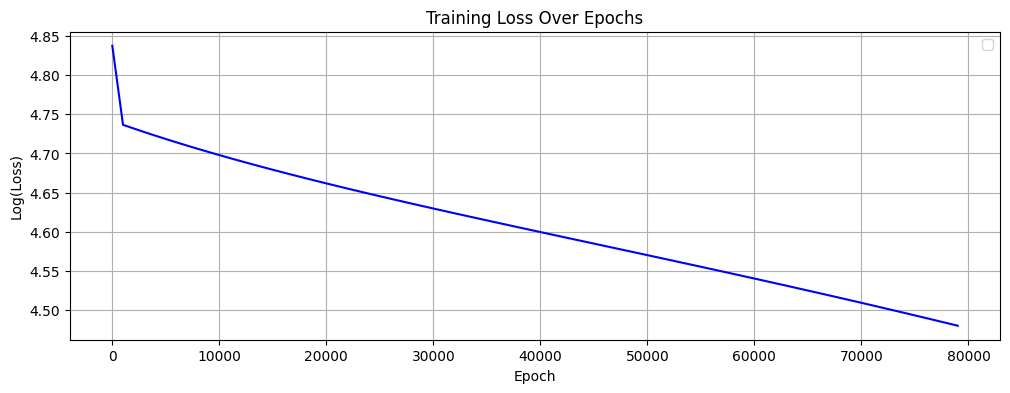

In [5]:
if __name__=='__main__':

    model_slow1  = slow_system_PINN1().to(torch.float64)
    model_fast1  = fast_system_PINN1().to(torch.float64)  
    model_slow2  = slow_system_PINN2().to(torch.float64)  
    model_fast2  = fast_system_PINN2().to(torch.float64) 
    model_slow3  = slow_system_PINN3().to(torch.float64)

    optimizer = torch.optim.Adam(list(model_slow1.parameters()) +\
                                 list(model_fast1.parameters()) +\
                                 list(model_slow2.parameters()) +\
                                 list(model_fast2.parameters()) +\
                                 list(model_slow3.parameters()), lr=1e-3)
    loss_values = []
    epoch_num = 80000

    for epoch in range(epoch_num):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_slow1, model_fast1, model_slow2, model_fast2, model_slow3,\
                                    tau1_tensor, t1_tensor, tau2_tensor, t2_tensor, tau3_tensor,\
                                    c1_init, c2_init, w_init, phi_init,\
                                    c1_end, c2_end, w_end, phi_end,\
                                    eps, weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()#(retain_graph=True)
        optimizer.step()
        with torch.no_grad():
            phi_pred_slow1, u_pred_slow1, c1_pred_slow1, c2_pred_slow1, j1_pred_slow1, j2_pred_slow1, w_pred_slow1 = model_slow1(tau1_tensor).numpy().T
            phi_pred_fast1, u_pred_fast1, c1_pred_fast1, c2_pred_fast1, j1_pred_fast1, j2_pred_fast1, w_pred_fast1 = model_fast1(t1_tensor).numpy().T
            phi_pred_slow2, u_pred_slow2, c1_pred_slow2, c2_pred_slow2, j1_pred_slow2, j2_pred_slow2, w_pred_slow2 = model_slow2(tau2_tensor).numpy().T
            phi_pred_fast2, u_pred_fast2, c1_pred_fast2, c2_pred_fast2, j1_pred_fast2, j2_pred_fast2, w_pred_fast2 = model_fast2(t2_tensor).numpy().T
            phi_pred_slow3, u_pred_slow3, c1_pred_slow3, c2_pred_slow3, j1_pred_slow3, j2_pred_slow3, w_pred_slow3 = model_slow3(tau3_tensor).numpy().T
            c1_s_a_l, c2_s_a_l, phi_s_a_l = c1_pred_slow1[-1], c2_pred_slow1[-1], phi_pred_slow1[-1]
            #c1_f_a_l, c2_f_a_l, phi_f_a_l = c1_pred_fast1[0], c2_pred_fast1[0], phi_pred_fast1[0]
            c1_s_a_r, c2_s_a_r, phi_s_a_r = c1_pred_slow2[0], c2_pred_slow2[0], phi_pred_slow2[0]
            #c1_f_a_r, c2_f_a_r, phi_f_a_r = c1_pred_fast1[-1], c2_pred_fast1[-1], phi_pred_fast1[-1]
            c1_s_b_l, c2_s_b_l, phi_s_b_l = c1_pred_slow2[-1], c2_pred_slow2[-1], phi_pred_slow2[-1]
            #c1_f_b_l, c2_f_b_l, phi_f_b_l = c1_pred_fast2[0], c2_pred_fast2[0], phi_pred_fast2[0]
            c1_s_b_r, c2_s_b_r, phi_s_b_r = c1_pred_slow3[0], c2_pred_slow3[0], phi_pred_slow3[0]
            #c1_f_b_r, c2_f_b_r, phi_f_b_r = c1_pred_fast2[-1], c2_pred_fast2[-1], phi_pred_fast2[-1]
            J1, J2   = j1_pred_slow1[-1] , j2_pred_slow1[-1]
            
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}') 
        loss_values.append(loss_total.item())
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 1000), np.log(loss_values[:epoch_num//1000]), 'b')#, label='Fast System')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Model evaluation
    model_slow1.eval()
    model_fast1.eval()
    model_slow2.eval()
    model_fast2.eval()
    model_slow3.eval()
    with torch.no_grad():
        # Predictions for fast system
        phi_pred_slow1, u_pred_slow1, c1_pred_slow1, c2_pred_slow1, j1_pred_slow1, j2_pred_slow1, w_pred_slow1 = model_slow1(tau1_tensor).numpy().T
        phi_pred_fast1, u_pred_fast1, c1_pred_fast1, c2_pred_fast1, j1_pred_fast1, j2_pred_fast1, w_pred_fast1 = model_fast1(t1_tensor).numpy().T
        phi_pred_slow2, u_pred_slow2, c1_pred_slow2, c2_pred_slow2, j1_pred_slow2, j2_pred_slow2, w_pred_slow2 = model_slow2(tau2_tensor).numpy().T
        phi_pred_fast2, u_pred_fast2, c1_pred_fast2, c2_pred_fast2, j1_pred_fast2, j2_pred_fast2, w_pred_fast2 = model_fast2(t2_tensor).numpy().T
        phi_pred_slow3, u_pred_slow3, c1_pred_slow3, c2_pred_slow3, j1_pred_slow3, j2_pred_slow3, w_pred_slow3 = model_slow3(tau3_tensor).numpy().T
        c1_s_a_l, c2_s_a_l, phi_s_a_l = c1_pred_slow1[-1], c2_pred_slow1[-1], phi_pred_slow1[-1]
        #c1_f_a_l, c2_f_a_l, phi_f_a_l = c1_pred_fast1[0], c2_pred_fast1[0], phi_pred_fast1[0]
        c1_s_a_r, c2_s_a_r, phi_s_a_r = c1_pred_slow2[0], c2_pred_slow2[0], phi_pred_slow2[0]
        #c1_f_a_r, c2_f_a_r, phi_f_a_r = c1_pred_fast1[-1], c2_pred_fast1[-1], phi_pred_fast1[-1]
        c1_s_b_l, c2_s_b_l, phi_s_b_l = c1_pred_slow2[-1], c2_pred_slow2[-1], phi_pred_slow2[-1]
        #c1_f_b_l, c2_f_b_l, phi_f_b_l = c1_pred_fast2[0], c2_pred_fast2[0], phi_pred_fast2[0]
        c1_s_b_r, c2_s_b_r, phi_s_b_r = c1_pred_slow3[0], c2_pred_slow3[0], phi_pred_slow3[0]
        #c1_f_b_r, c2_f_b_r, phi_f_b_r = c1_pred_fast2[-1], c2_pred_fast2[-1], phi_pred_fast2[-1]
        J1, J2   = j1_pred_slow1[-1] , j2_pred_slow1[-1]
    

In [6]:
#print(J1)
#print(J2)
print(j1_pred_slow1.shape)
print(j1_pred_slow1[0])
print(j1_pred_slow1[-1])
print('')


print(j1_pred_fast1[0])
print(j1_pred_fast1[-1])
print('')

print(j1_pred_slow2[0])
print(j1_pred_slow2[-1])
print('')


print(j1_pred_fast2[0])
print(j1_pred_fast2[-1])
print('')

print(j1_pred_slow3[0])
print(j1_pred_slow3[-1])
print('')


(100,)
-0.16458228907674988
-0.1645991324702306

-0.16544670101257078
-0.17174385190755728

-0.16568882589584763
-0.16568440960188813

-0.16394905405422916
-0.1631272172057155

-0.165845081432887
-0.16583158900199663



In [7]:
print(j2_pred_slow1.shape)
print(j2_pred_slow1[0])
print(j2_pred_slow1[-1])
print('')


print(j2_pred_fast1[0])
print(j2_pred_fast1[-1])
print('')

(100,)
0.6806929037850908
0.6806742277979335

0.6903244644092275
0.689314431413223



In [8]:
print(u_pred_slow1.shape)
print(u_pred_slow1[0])
print(u_pred_slow1[-1])
print('')


print(u_pred_fast1[0])
print(u_pred_fast1[-1])
print('')

u_length = len(u_pred_slow1)
print('u_length=',u_length)
zero_vector = np.zeros(u_length)

(100,)
8.676108310735203e-05
8.579953241723282e-05

0.042163914019682766
0.04348985802532668

u_length= 100


In [9]:
print(z1*c1_pred_fast1[0] + z2*c2_pred_fast1[0])
print('')
print(z1*c1_pred_fast2[0] + z2*c2_pred_fast2[0])

-0.01539548679472591

-0.2016137859092753


In [10]:
print(w_pred_slow1.shape)
print(np.max(w_pred_slow1))
print(w_pred_slow1[-1])
print('')

print(w_pred_fast1[0])
print(w_pred_fast1[-1])
print(np.max(w_pred_fast1))
print(np.min(w_pred_fast1))
print('')

print(w_pred_slow2[0])
print(w_pred_slow2[-1])
print('')

print(w_pred_fast2[0])
print(w_pred_fast2[-1])
print(np.max(w_pred_fast2))
print(np.min(w_pred_fast2))
print('')

print(w_pred_slow3[0])
print(w_pred_slow3[-1])
print('')

(100,)
0.3307475399073905
0.3307475399073905

0.3330837057846594
0.33326182730704856
0.3332793531586718
0.3330283882735185

0.33244292976449724
0.665772572836671

0.6664838979712431
0.6669592663656879
0.6670076783460498
0.6664838979712431

0.6679386585703618
1.001330172698619



<ipython-input-11-2c445c507890>:45: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-11-2c445c507890>:46: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-11-2c445c507890>:47: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-11-2c445c507890>:73: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


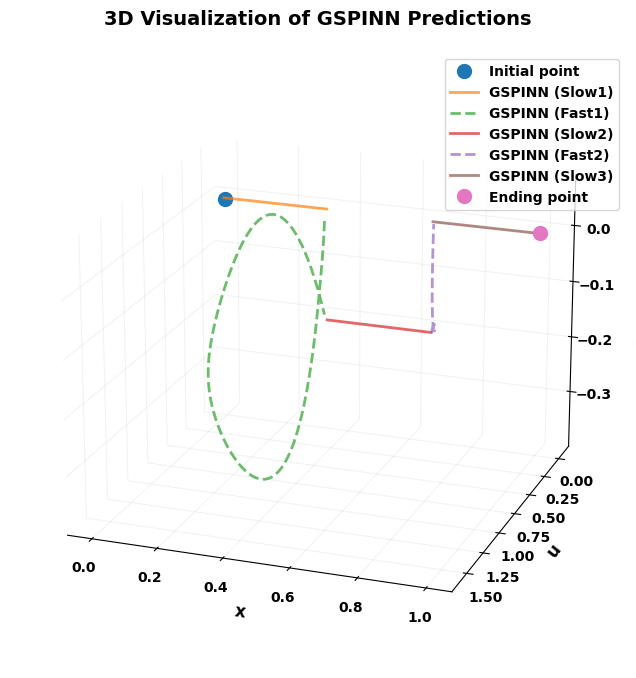

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Assuming z1, z2, c1_init, c2_init, etc. are defined elsewhere in your code
zc_init = z1 * c1_init + z2 * c2_init
zc_s1 = z1 * c1_pred_slow1 + z2 * c2_pred_slow1
zc_f1 = z1 * c1_pred_fast1 + z2 * c2_pred_fast1
zc_s2 = z1 * c1_pred_slow2 + z2 * c2_pred_slow2
zc_f2 = z1 * c1_pred_fast2 + z2 * c2_pred_fast2
zc_s3 = z1 * c1_pred_slow3 + z2 * c2_pred_slow3
zc_end = z1 * c1_end + z2 * c2_end

# Create the figure and 3D axis
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')  # Set the background color of the 3D plot

# Custom color scheme
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Plot the data with enhanced visual settings
ax.plot(w_init, u_0, zc_init, 'o', color=colors[0], markersize=10, label='Initial point')
ax.plot(w_pred_slow1, u_pred_slow1, zc_s1, '-', color=colors[1], linewidth=2, label='GSPINN (Slow1)', alpha=0.7)
ax.plot(w_pred_fast1, u_pred_fast1, zc_f1, '--', color=colors[2], linewidth=2, label='GSPINN (Fast1)', alpha=0.7)
ax.plot(w_pred_slow2, u_pred_slow2, zc_s2, '-', color=colors[3], linewidth=2, label='GSPINN (Slow2)', alpha=0.7)
ax.plot(w_pred_fast2, u_pred_fast2, zc_f2, '--', color=colors[4], linewidth=2, label='GSPINN (Fast2)', alpha=0.7)
ax.plot(w_pred_slow3, u_pred_slow3, zc_s3, '-', color=colors[5], linewidth=2, label='GSPINN (Slow3)', alpha=0.7)
ax.plot(w_end, u_pred_fast2[0], zc_end, 'o', color=colors[6], markersize=10, label='Ending point')

# Set labels with enhanced font settings
ax.set_xlabel('$\\mathbf{x}$', fontsize=12, fontweight='bold', color='black')
ax.set_ylabel('$\\mathbf{u}$', fontsize=12, fontweight='bold', color='black')
ax.set_zlabel('$\\mathbf{z_1 c_1 + z_2 c_2}$', fontsize=12, fontweight='bold', color='black', labelpad=15)

# Customize the legend
legend = ax.legend(prop={'weight': 'bold', 'size': 10})#, loc='upper right', bbox_to_anchor=(1.1, 1))
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.8)

# Invert the x-axis
ax.invert_xaxis()

# Set the pane colors to white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Set the grid colors to very light gray
ax.xaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05)) 
ax.yaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))
ax.zaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))

# Update tick label properties
ax.tick_params(axis='x', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='y', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='z', labelsize=10, labelcolor='black', width=2, length=5)

# Apply bold font to tick labels
for label in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels():
    label.set_fontweight('bold')

# Rotating the figure by 20 degrees
ax.view_init(elev=20, azim=110)

# Add a grid with low opacity
plt.grid(True, alpha=0.1)

# Add a title
plt.title('3D Visualization of GSPINN Predictions', fontsize=14, fontweight='bold', pad=20)

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
u_pred_fast1[0]

0.042163914019682766

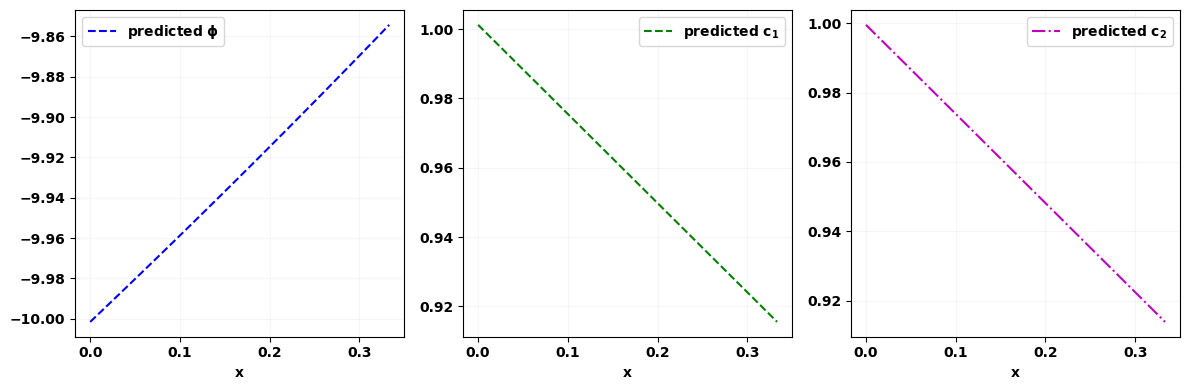

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(tau1, phi_pred_slow1, 'b--', label='predicted $\\mathbf{\\phi}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau1, c1_pred_slow1, 'g--', label='predicted $\\mathbf{c_1}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(tau1, c2_pred_slow1, 'm-.', label='predicted $\\mathbf{c_2}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


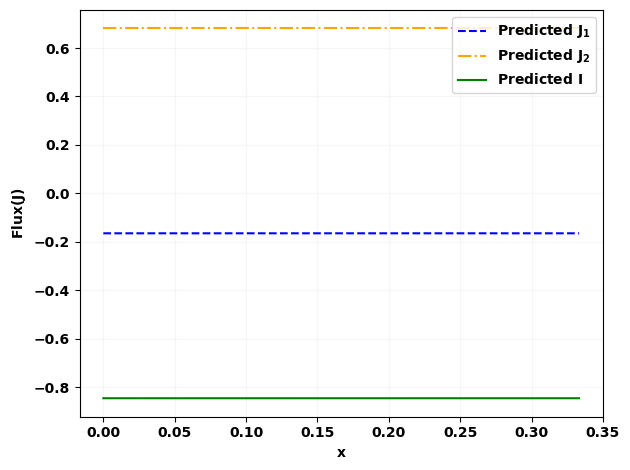

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.4, 4.8))

# Plot the data
plt.plot(tau1, j1_pred_slow1, 'b--', label='Predicted $\\mathbf{J_1}$')
plt.plot(tau1, j2_pred_slow1, '-.', color='orange', label='Predicted $\\mathbf{J_2}$')
plt.plot(tau1, z1*j1_pred_slow1 + z2*j2_pred_slow1, '-', color='green', label='Predicted $\\mathbf{I}$')

# Label the axes
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{Flux (J)}$', fontweight='bold')

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Add grid and legend
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


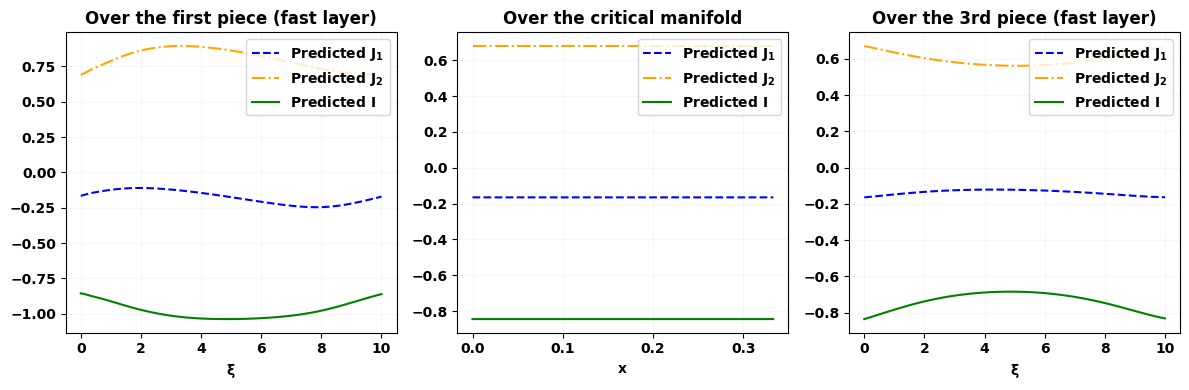

array([0.67163222, 0.66813534])

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t1, j1_pred_fast1, 'b--', label='Predicted $\\mathbf{J_1}$')
plt.plot(t1, j2_pred_fast1, '-.', color='orange', label='Predicted $\\mathbf{J_2}$')
plt.plot(t1, z1*j1_pred_fast1 + z2*j2_pred_fast1, '-', color='green', label='Predicted $\\mathbf{I}$')

plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title('Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau2, j1_pred_slow2, 'b--', label='Predicted $\\mathbf{J_1}$')
plt.plot(tau2, j2_pred_slow2, '-.', color='orange', label='Predicted $\\mathbf{J_2}$')
plt.plot(tau2, z1*j1_pred_slow2 + z2*j2_pred_slow2, '-', color='green', label='Predicted $\\mathbf{I}$')

plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.title('Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, j1_pred_fast2 , 'b--', label='Predicted $\\mathbf{J_1}$')
plt.plot(t2, j2_pred_fast2 , '-.', color='orange', label='Predicted $\\mathbf{J_2}$')
plt.plot(t2, z1*j1_pred_fast2 + z2*j2_pred_fast2, '-', color='green', label='Predicted $\\mathbf{I}$')

plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title('Over the 3rd piece (fast layer)', fontweight='bold')
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()
j2_pred_fast2[:2]

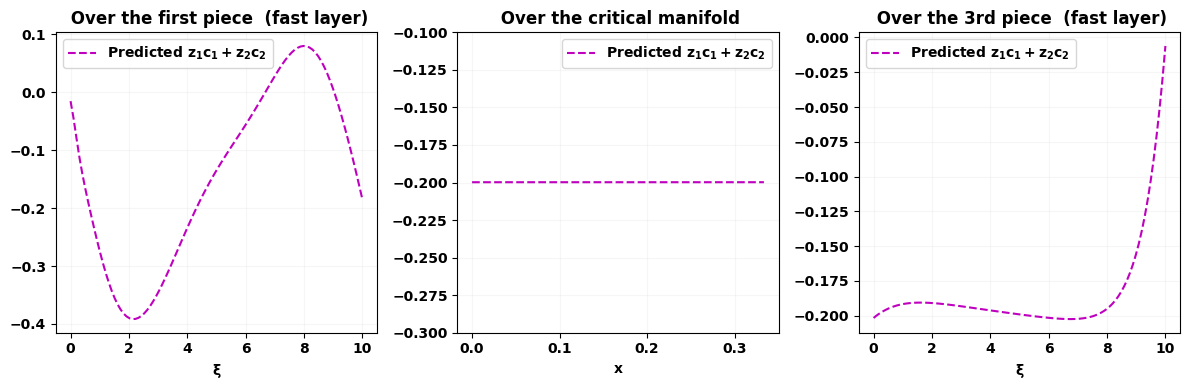

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t1, z1 * c1_pred_fast1 + z2 * c2_pred_fast1, 'm--', label='Predicted $\\mathbf{z_1 c_1+ z_2  c_2}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the first piece  (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')


plt.subplot(1, 3, 2)
plt.plot(tau2, z1 * c1_pred_slow2 + z2 * c2_pred_slow2 , 'm--', label='Predicted $\\mathbf{z_1 c_1+ z_2  c_2}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylim(-0.3, -0.1)
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, z1 * c1_pred_fast2 + z2 * c2_pred_fast2, 'm--', label='Predicted $\\mathbf{z_1 c_1+ z_2  c_2}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the 3rd piece  (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


### In the following, we would like to investigate whether the variables are fast or slow based on their dynamic on fast layers and slow layer:

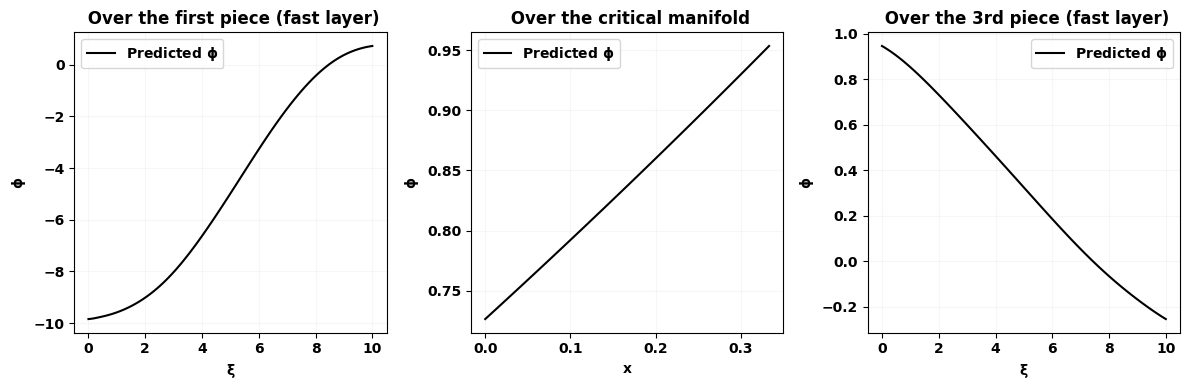

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t1, phi_pred_fast1, 'k-', label='Predicted $\\mathbf{\\phi}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{\\phi}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau2, phi_pred_slow2, 'k-', label='Predicted $\\mathbf{\\phi}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{\\phi}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, phi_pred_fast2 , 'k-', label='Predicted $\\mathbf{\\phi}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{\\phi}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


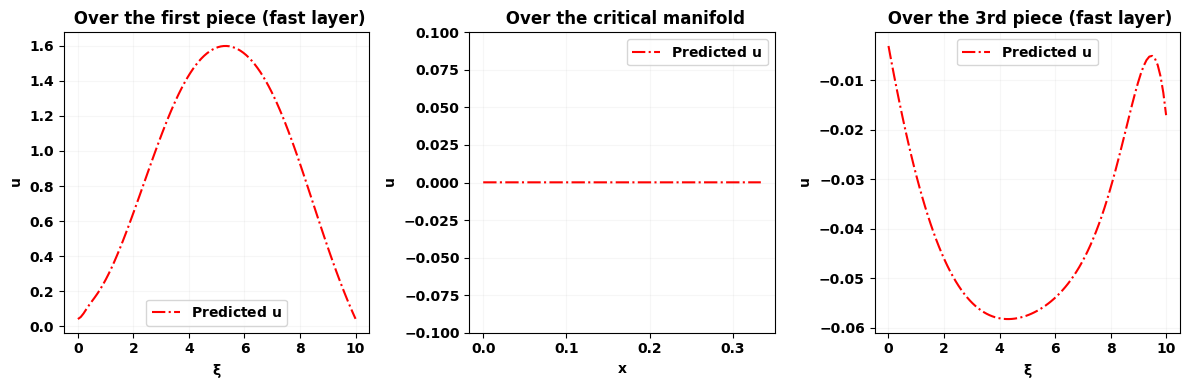

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t1, u_pred_fast1, 'r-.', label='Predicted $\\mathbf{u}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{u}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau2, u_pred_slow2, 'r-.', label='Predicted $\\mathbf{u}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{u}$', fontweight='bold')
plt.ylim(-0.1, 0.1)
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, u_pred_fast2, 'r-.', label='Predicted $\\mathbf{u}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{u}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


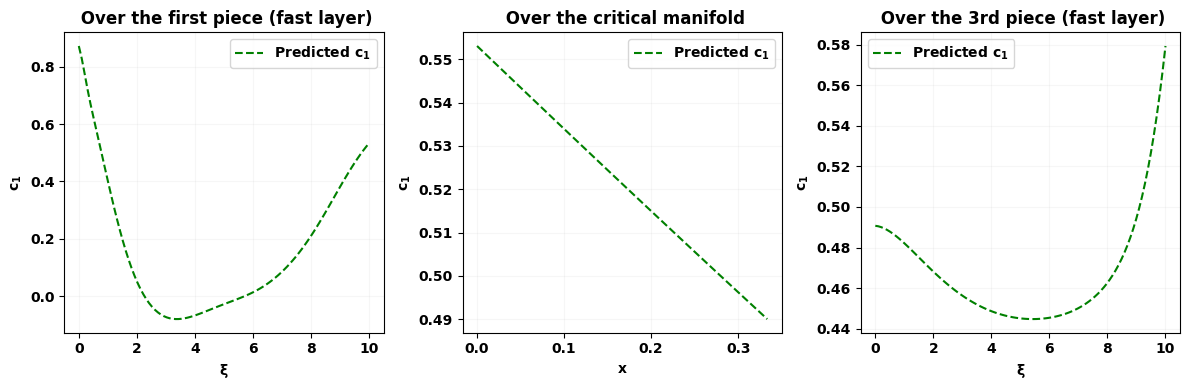

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t1, c1_pred_fast1, 'g--', label='Predicted $\\mathbf{c_1}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_1}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau2, c1_pred_slow2, 'g--', label='Predicted $\\mathbf{c_1}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_1}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, c1_pred_fast2, 'g--', label='Predicted $\\mathbf{c_1}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_1}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


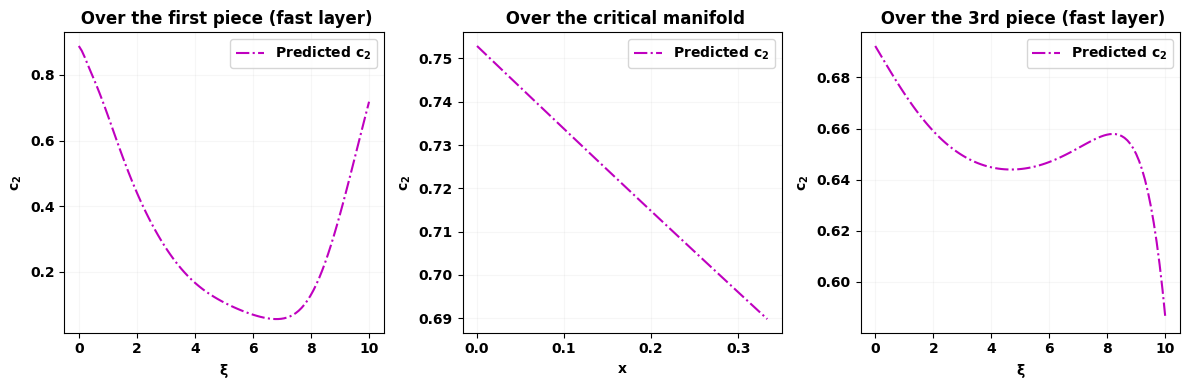

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t1, c2_pred_fast1, 'm-.', label='Predicted $\\mathbf{c_2}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_2}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau2, c2_pred_slow2, 'm-.', label='Predicted $\\mathbf{c_2}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_2}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, c2_pred_fast2, 'm-.', label='Predicted $\\mathbf{c_2}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_2}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()


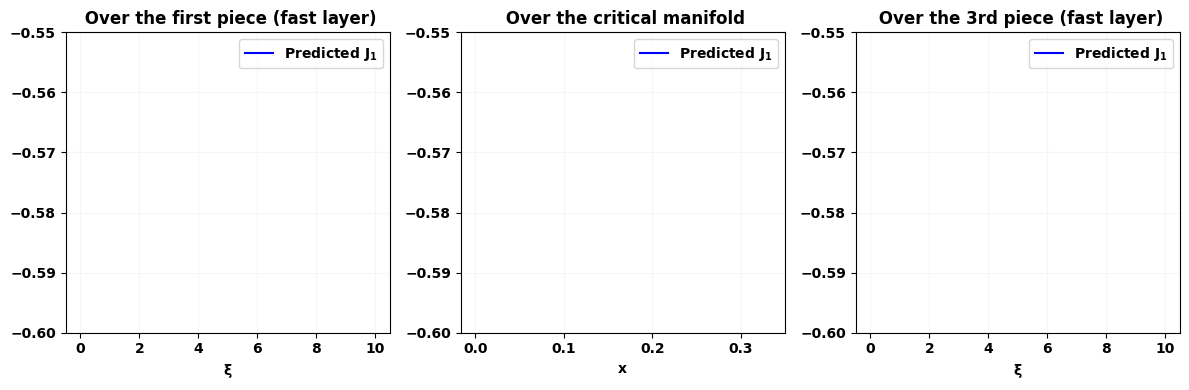

array([-0.16394905, -0.16239283, -0.16079143, -0.15915515, -0.15749379])

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t1, j1_pred_fast1, 'b-', label='Predicted $\\mathbf{J_1}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})
plt.ylim(-0.6, -0.55)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau2, j1_pred_slow2, 'b-', label='Predicted $\\mathbf{J_1}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})
plt.ylim(-0.6, -0.55)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, j1_pred_fast2, 'b-', label='Predicted $\\mathbf{J_1}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.legend(prop={'weight': 'bold'})
plt.ylim(-0.6, -0.55)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

j1_pred_fast2[:5]


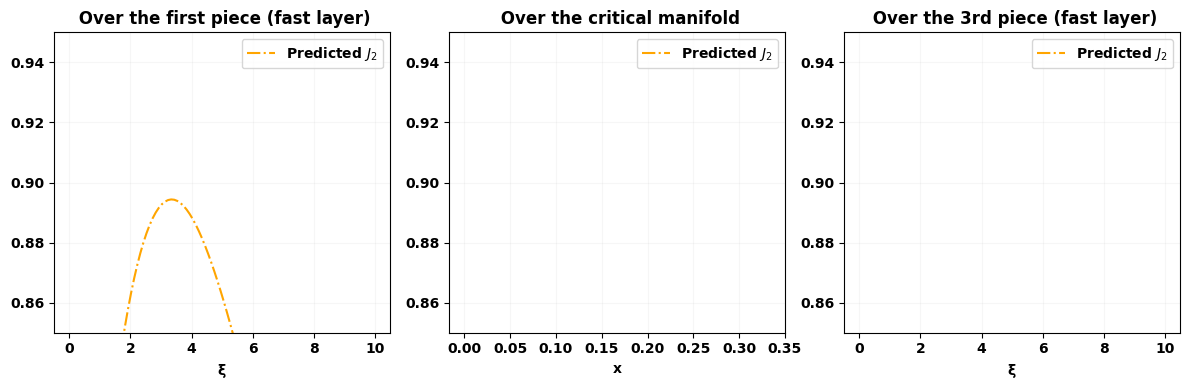

array([0.67163222, 0.66813534, 0.66458243, 0.66098811, 0.65736631])

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t1, j2_pred_fast1, '-.', color='orange', label='Predicted $J_2$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})
plt.ylim(0.85, 0.95)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau2, j2_pred_slow2, '-.', color='orange', label='Predicted $J_2$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})
plt.ylim(0.85, 0.95)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, j2_pred_fast2, '-.', color='orange', label='Predicted $J_2$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.legend(prop={'weight': 'bold'})
plt.ylim(0.85, 0.95)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

j2_pred_fast2[:5]